<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Download and visualise BGC data over an ocean region

This notebook shows how to:
- download BGC-Argo data for a space/time domain
- plot a map with floats trajectory
- plot BGC data

## Import and set-up

In [60]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [13]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

## Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [14]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-35, -10, 55, 67, 0, 2000, '2010-01', '2024-12']

## Get more info about this region using the ArgoIndex

In [15]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (362897 records)
Searched: False

In [20]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [21]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [22]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE']]  # Remove core variables from the list
bgc_params

['BBP532',
 'BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PRES',
 'PSAL',
 'TEMP']

In [23]:
# How many different floats in the region:
len(idx.read_wmo())

107

## Load all data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [24]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='bgc', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 19min 7s, sys: 1min 8s, total: 20min 15s
Wall time: 1h 26s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-35.00/-10.00; y=55.00/67.00; z=0.0/2000.0; t=2010-01-01/2024-12-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['BBP532', 'BBP700', 'BISULFIDE', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'DOXY2', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
📕 BGC 'must be measured' parameters: []
🏄 User mode: expert
🟢 Dataset: bgc-s
🌤  Performances: cache=False, parallel=True [thread]

In [55]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 3GB
Dimensions:                            (N_POINTS: 4455053)
Coordinates:
    LATITUDE                           (N_POINTS) float64 36MB 56.25 ... 61.32
    LONGITUDE                          (N_POINTS) float64 36MB -27.29 ... -16.05
    TIME                               (N_POINTS) datetime64[ns] 36MB 2010-06...
  * N_POINTS                           (N_POINTS) int64 36MB 0 1 ... 4455052
Data variables: (12/108)
    BBP532                             (N_POINTS) float32 18MB nan nan ... nan
    BBP532_ADJUSTED                    (N_POINTS) float32 18MB nan nan ... nan
    BBP532_ADJUSTED_ERROR              (N_POINTS) float32 18MB nan nan ... nan
    BBP532_ADJUSTED_QC                 (N_POINTS) int64 36MB 99999 ... 99999
    BBP532_DATA_MODE                   (N_POINTS) <U1 18MB '' '' '' ... '' '' ''
    BBP532_QC                          (N_POINTS) int64 36MB 99999 ... 99999
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 18MB 12.04 ... 3.698
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 18MB 0.002 ... 0.002
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 36MB 1 1 1 1 ... 1 1 1 1
    TEMP_DATA_MODE                     (N_POINTS) <U1 18MB 'D' 'D' ... 'D' 'D'
    TEMP_QC                            (N_POINTS) int64 36MB 1 1 1 1 ... 1 1 1 1
    TIME_QC                            (N_POINTS) int64 36MB 1 1 1 1 ... 1 1 1 1
Attributes: (7)

In [56]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(4455053) ~ N_PROF(6368) x N_LEVELS(4670)

In [57]:
import polars as pl
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds[variables].to_dataframe()) 

Had to change directoy stuff


In [62]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/argo_pq'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'argo_pq' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/argo_pq/icb_floats_table.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

file                date  latitude  \
0     aoml/1902304/profiles/SD1902304_157.nc 2024-03-21 21:21:39    55.297   
1     aoml/1902304/profiles/SD1902304_158.nc 2024-03-31 21:31:53    55.727   
2     aoml/1902304/profiles/SD1902304_159.nc 2024-04-10 21:11:20    56.325   
3     aoml/1902304/profiles/SD1902304_160.nc 2024-04-20 21:24:52    56.290   
4     aoml/1902304/profiles/SD1902304_161.nc 2024-04-30 21:30:20    56.509   
...                                      ...                 ...       ...   
6333  meds/4901779/profiles/SD4901779_188.nc 2020-07-06 13:45:00    62.149   
6334  meds/4901779/profiles/SD4901779_189.nc 2020-07-16 13:47:00    62.034   
6335  meds/4901779/profiles/SD4901779_190.nc 2020-07-26 13:40:00    62.145   
6336  meds/4901779/profiles/SD4901779_191.nc 2020-08-05 13:41:00    62.195   
6337  meds/4902487/profiles/SR4902487_097.nc 2022-02-03 04:22:00    62.298   

      longitude ocean  profiler_code institution_code  \
0       -18.833     A            869               AO   
1       -18.865     A            869               AO   
2       -18.987     A            869               AO   
3       -18.758     A            869               AO   
4       -18.912     A            869               AO   
...         ...   ...            ...              ...   
6333    -32.082     A            865               ME   
6334    -33.050     A            865               ME   
6335    -32.631     A            865               ME   
6336    -33.967     A            865               ME   
6337    -33.144     A            844               ME   

                                             parameters parameter_data_mode  \
0     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDDAAARDD   
1     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDDAAARDD   
2     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDDAAARDD   
3     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDDAAARDD   
4     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDDAAARDD   
...                                                 ...                 ...   
6333                                PRES TEMP PSAL DOXY                DDDR   
6334                                PRES TEMP PSAL DOXY                DDDR   
6335                                PRES TEMP PSAL DOXY                DDDR   
6336                                PRES TEMP PSAL DOXY                DDDR   
6337                                     PRES TEMP PSAL                 RRR   

             date_update      wmo  cyc   institution   dac  \
0    2025-08-28 01:31:37  1902304  157     AOML, USA  aoml   
1    2025-08-28 01:31:48  1902304  158     AOML, USA  aoml   
2    2025-08-28 01:31:59  1902304  159     AOML, USA  aoml   
3    2025-08-28 01:32:10  1902304  160     AOML, USA  aoml   
4    2025-08-28 01:32:21  1902304  161     AOML, USA  aoml   
...                  ...      ...  ...           ...   ...   
6333 2025-10-09 23:20:08  4901779  188  MEDS, Canada  meds   
6334 2025-10-09 23:20:17  4901779  189  MEDS, Canada  meds   
6335 2025-10-09 23:20:27  4901779  190  MEDS, Canada  meds   
6336 2025-10-09 23:20:36  4901779  191  MEDS, Canada  meds   
6337 2022-06-29 02:17:51  4902487   97  MEDS, Canada  meds   

                                      profiler  
0                                    NAVIS_EBR  
1                                    NAVIS_EBR  
2                                    NAVIS_EBR  
3                                    NAVIS_EBR  
4                                    NAVIS_EBR  
...                                        ...  
6333   NOVA float with SBE conductivity sensor  
6334   NOVA float with SBE conductivity sensor  
6335   NOVA float with SBE conductivity sensor  
6336   NOVA float with SBE conductivity sensor  
6337  ARVOR float with SBE conductivity sensor  

[6336 rows x 15 columns]

## Make a map with all floats trajectory

Rq: we could have done this without downloading the data by working directly with the ArgoIndex

```python
scatter_map(idx.to_dataframe(), set_global=False);
```

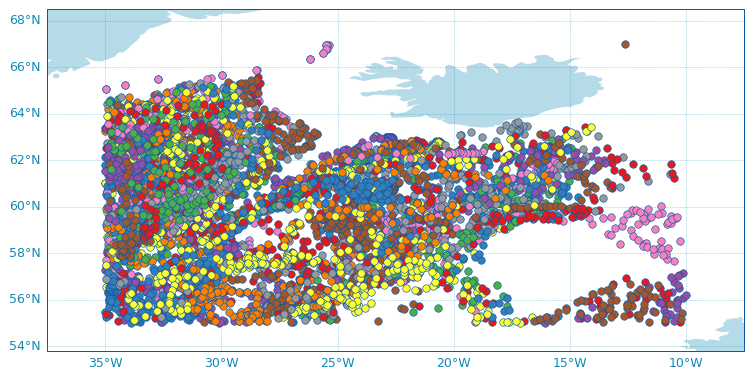

In [ ]:
# But here, we use the index retrieved with the DataFetcher:
scatter_map(df, traj=False, set_global=False, legend=False);

## Make a map with one BGC parameter data mode

We can also make a scatter map with one BGC parameter data mode.

In [ ]:
# Randomly select one BGC parameter to work with:
a_param = bgc_params[np.random.randint(len(bgc_params))]
a_param

'CDOM'

In [ ]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

{'altLabel': 'CDOM',
 'prefLabel': 'Concentration of coloured dissolved organic matter in sea water',
 'definition': 'Coloured dissolved organic matter (CDOM) concentration. Local_Attributes:{long_name:Concentration of coloured dissolved organic matter in sea water; standard_name:-; units:ppb; valid_min:-; valid_max:-; category:b; fill_value:99999.f; data_type:float}.',
 'deprecated': 'false',
 'id': 'http://vocab.nerc.ac.uk/collection/R03/current/CDOM/'}

In [ ]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

In [ ]:
np.unique(df["%s_DM" % a_param])

array(['', 'R'], dtype=object)

ValueError: too many values to unpack (expected 2)

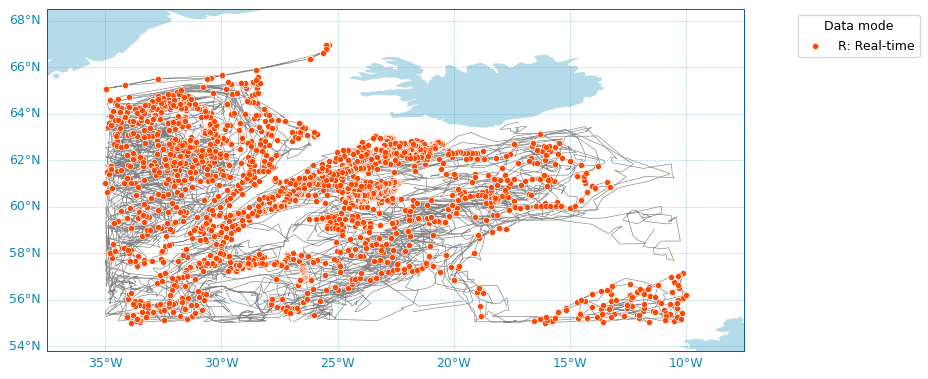

In [ ]:
# Finally plot the map:
fig, ax = scatter_map(df,
                        hue="%s_DM" % a_param,
                        cmap="data_mode",
                        markersize=24,
                        markeredgecolor='w',
                        traj_color='gray',
                        legend_title='Data mode')
ax.set_title("Data mode for %s (%s)\n%i profiles from the %s\n%i profiles downloaded" % (param_info['prefLabel'], a_param, 
                                                                           idx.N_MATCH, idx.convention_title, df.shape[0]));

**Rq**: If some points have no data mode in the above map, it simply means that these profiles have not the request parameters

## Plot 

### Utilities

We will be using the argopy scatter_plot method that has the following signature:

```
scatter_plot(
    ds: xarray.core.dataset.Dataset,
    this_param,
    this_x='TIME',
    this_y='PRES',
    figsize=(18, 6),
    cmap=None,
    vmin=None,
    vmax=None,
    s=4,
)
```

In [ ]:
# Try to define readible color bounds for each BGC variables 
# (this is probably NOT appropriate for all regions and periods !)
c_bounds = {'BBP700': (20e-5, 70e-5),
            'CDOM': (0.4, 0.8),
            'CHLA': (0, 0.2),
            'DOWNWELLING_PAR': (0, 10),
            'DOWN_IRRADIANCE380': (0, .1),
            'DOWN_IRRADIANCE412': (0, .1),
            'DOWN_IRRADIANCE490': (0, .1),
            'DOXY': (250,300),
            'NITRATE': (-2, 20),
            'PH_IN_SITU_TOTAL': (6, 8.5),
           }

In [ ]:
# We''l make use of the argopy color scheme:
ArgoColors('qc')

### Plot some data QC

ValueError: too many values to unpack (expected 2)

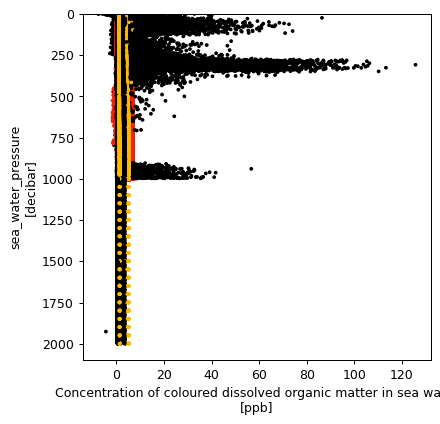

In [ ]:
fig, ax = scatter_plot(ds, a_param + '_QC', this_x = a_param, 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

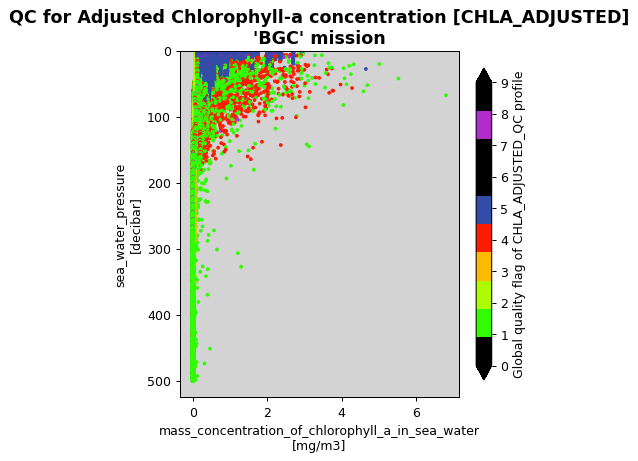

In [ ]:
fig, ax = scatter_plot(ds, a_param + '_ADJUSTED_QC', this_x = a_param + '_ADJUSTED', 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for Adjusted %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param + '_ADJUSTED', f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

### Plot some variable against another

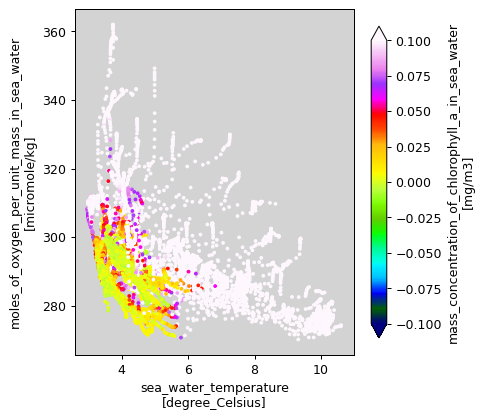

In [ ]:
fig, ax = scatter_plot(ds, 'CHLA_ADJUSTED', this_x = 'TEMP_ADJUSTED', this_y = 'DOXY_ADJUSTED', figsize=(5,5))

### Plot time series

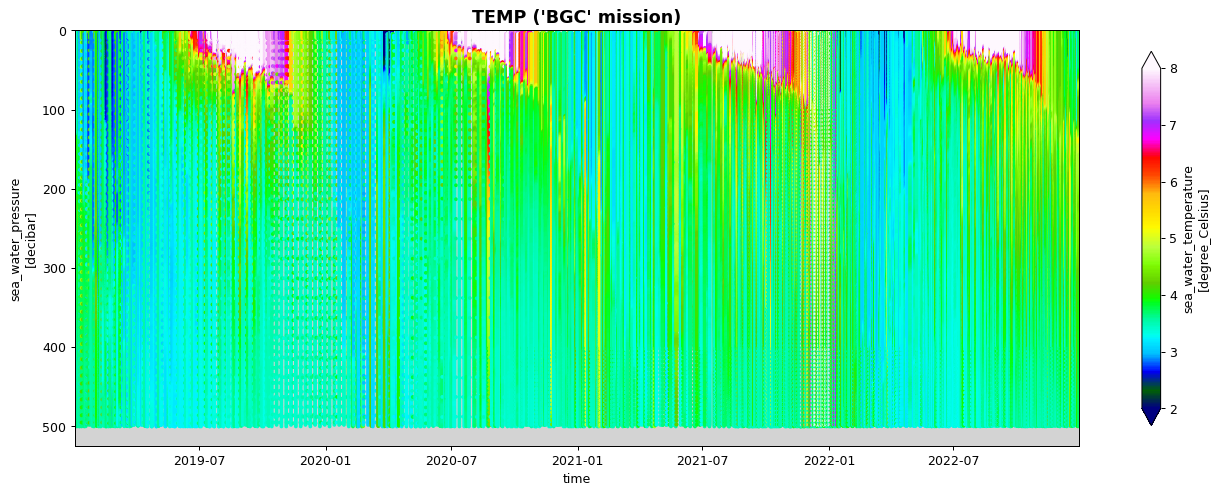

In [ ]:
fig, ax = scatter_plot(ds, 'TEMP', vmin=2, vmax=8)
ax.set_title("%s ('%s' mission)" % ('TEMP', f.mission), fontdict={'weight': 'bold', 'size': 14});

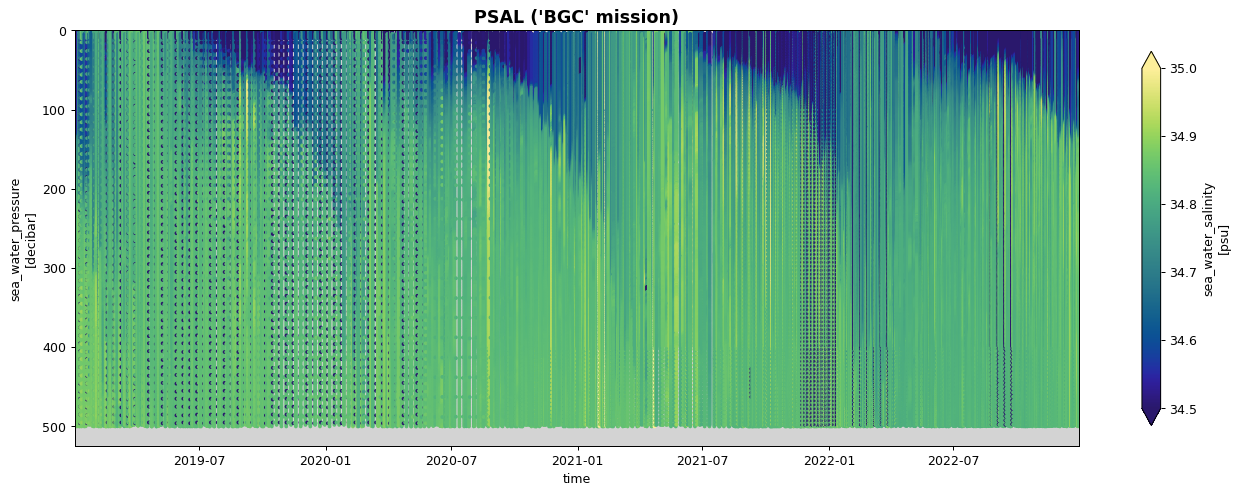

In [ ]:
fig, ax = scatter_plot(ds, 'PSAL', cmap=cmocean.cm.haline, vmin=34.5, vmax=35)
ax.set_title("%s ('%s' mission)" % ('PSAL', f.mission), fontdict={'weight': 'bold', 'size': 14});

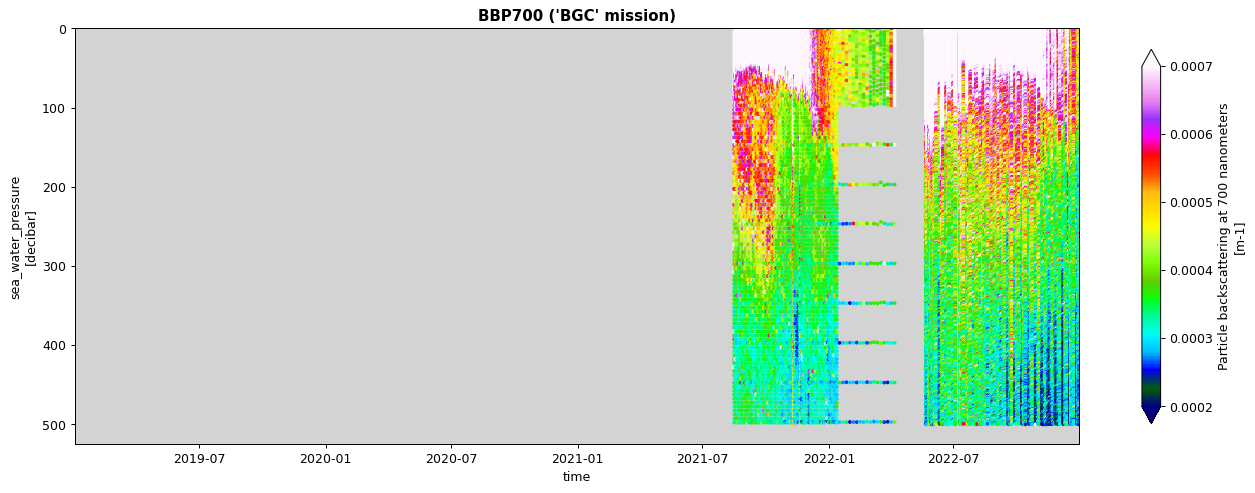

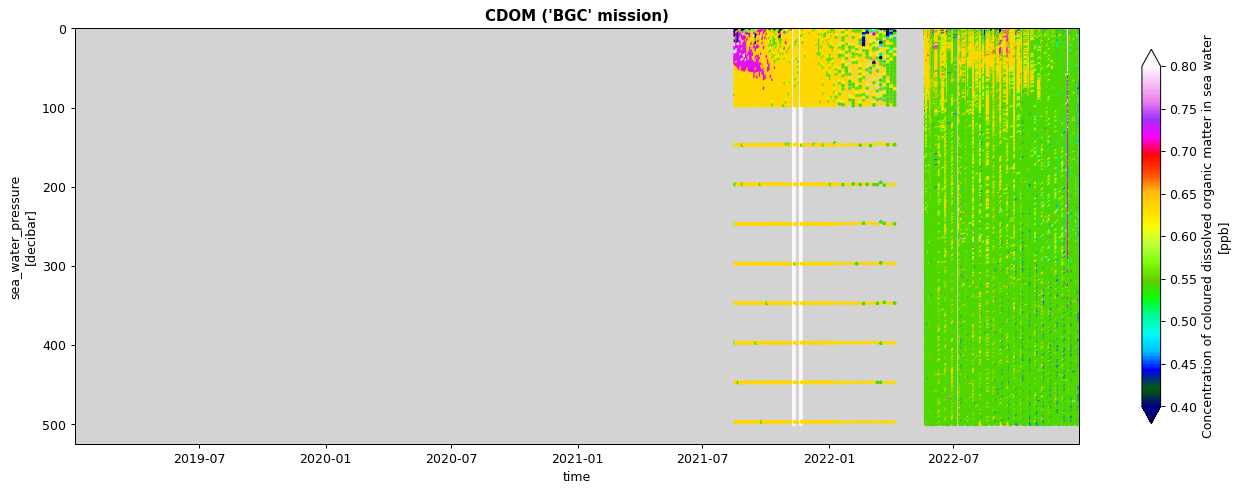

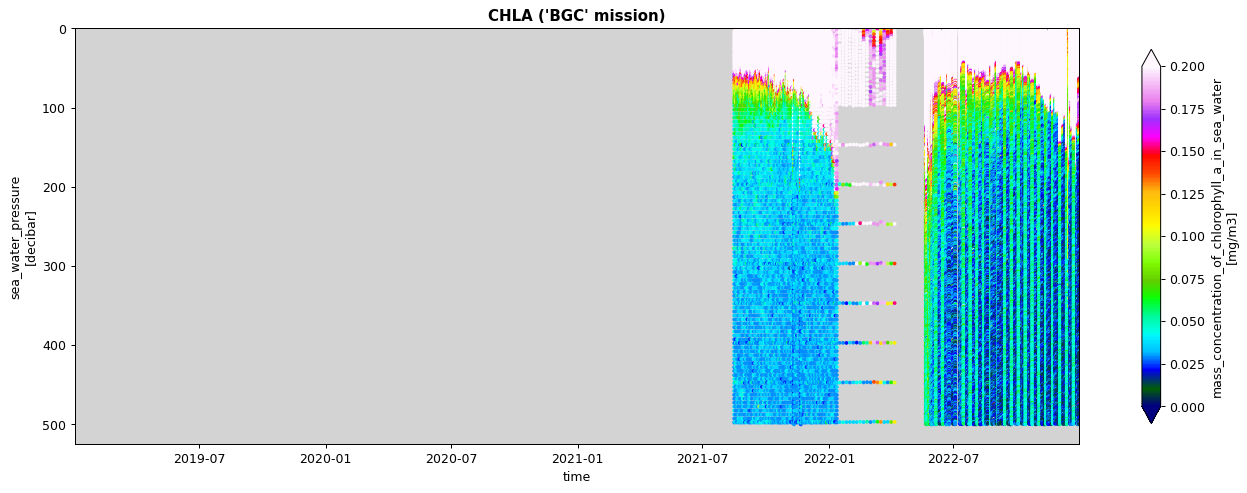

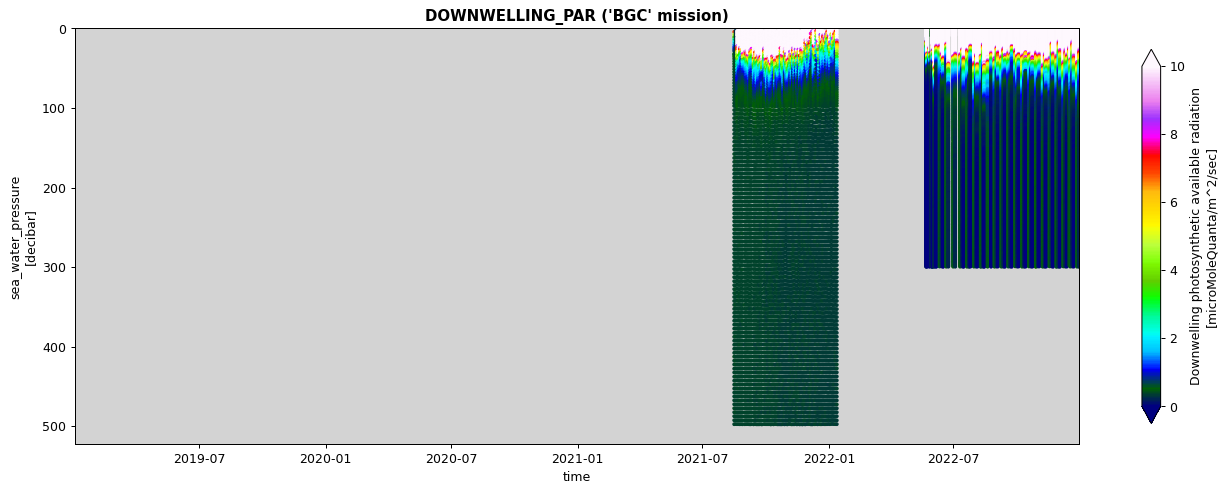

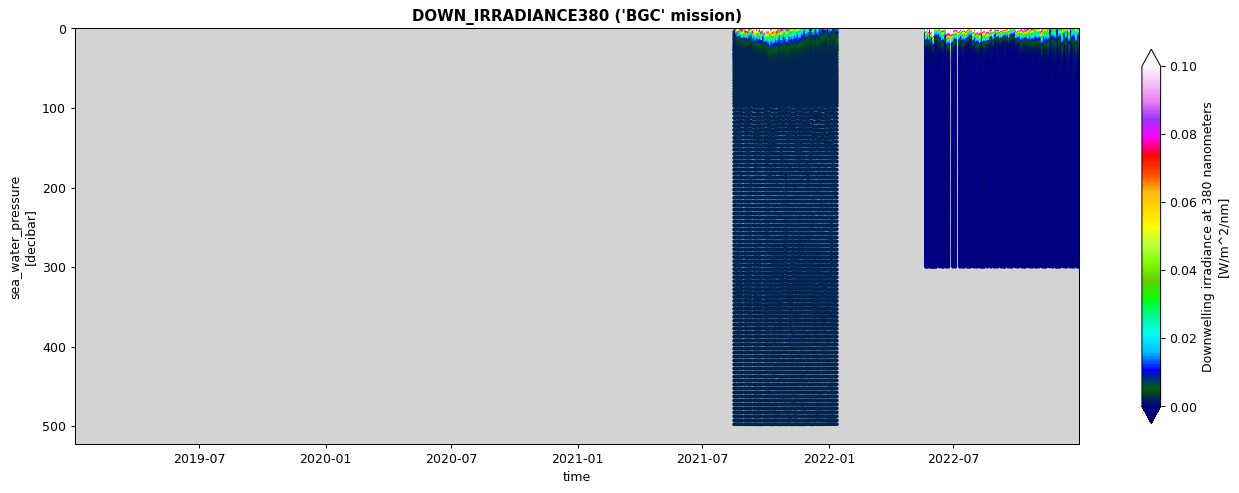

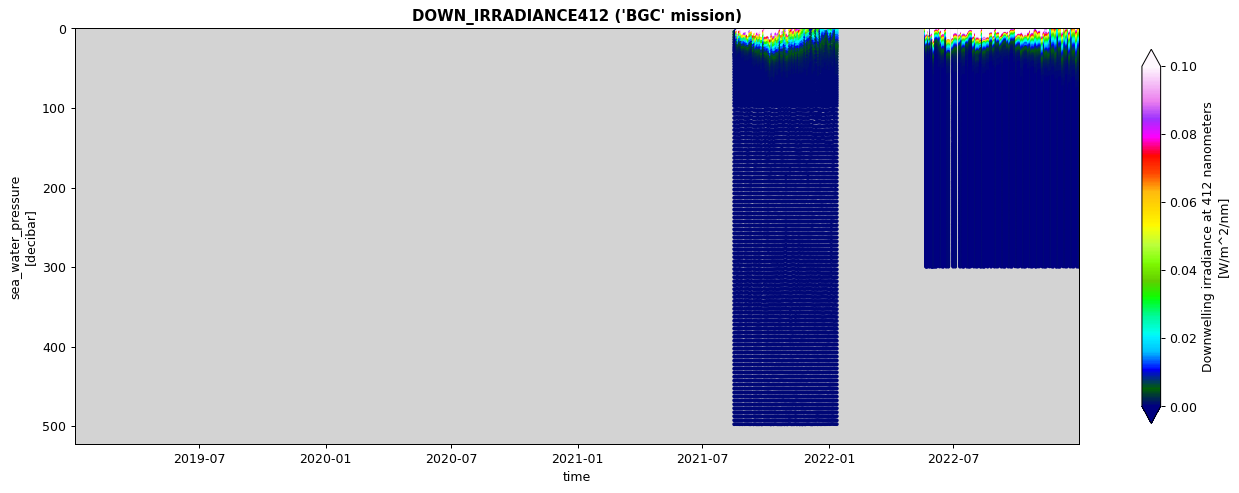

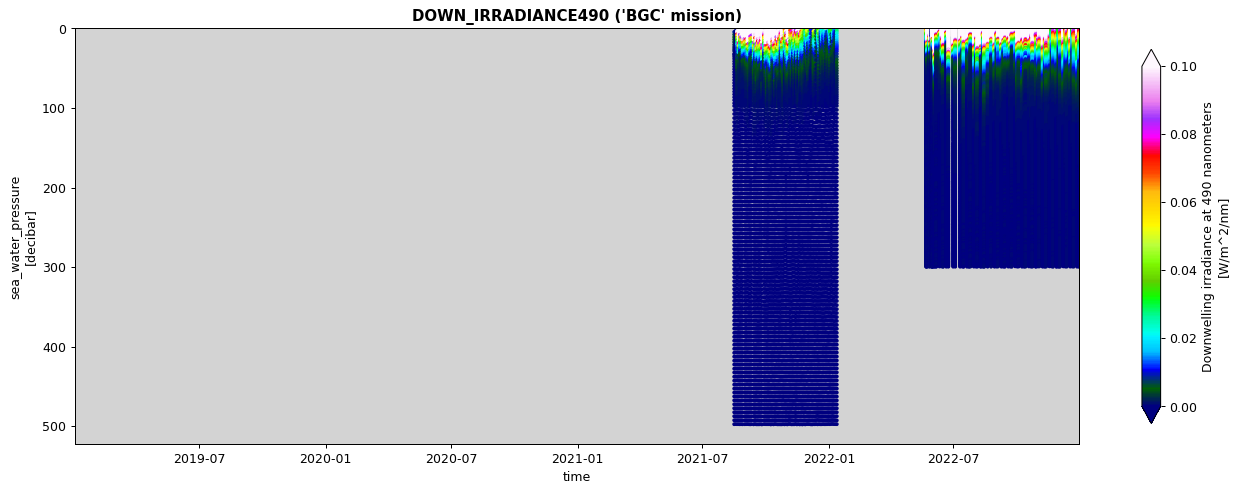

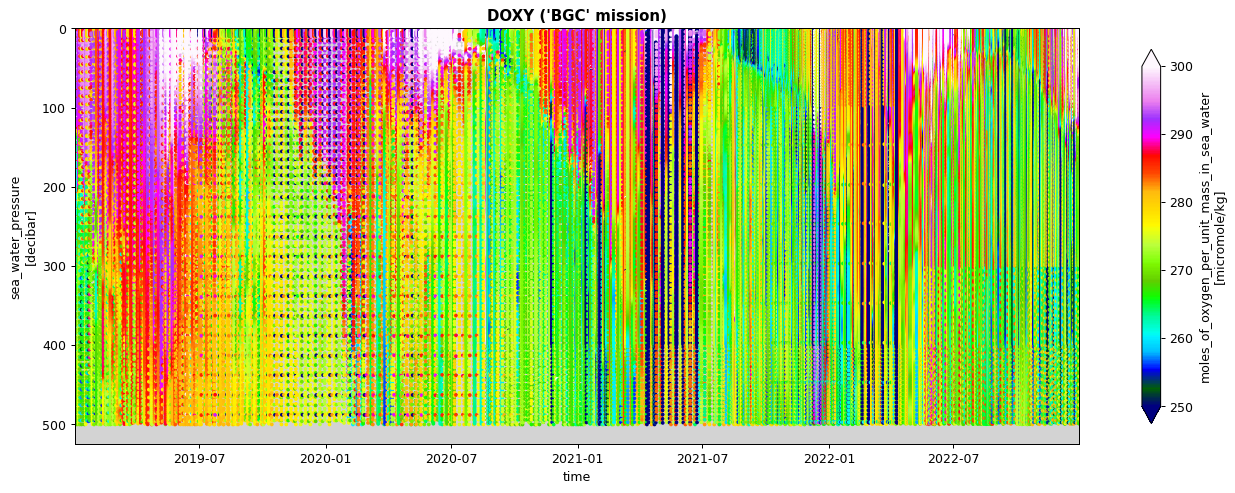

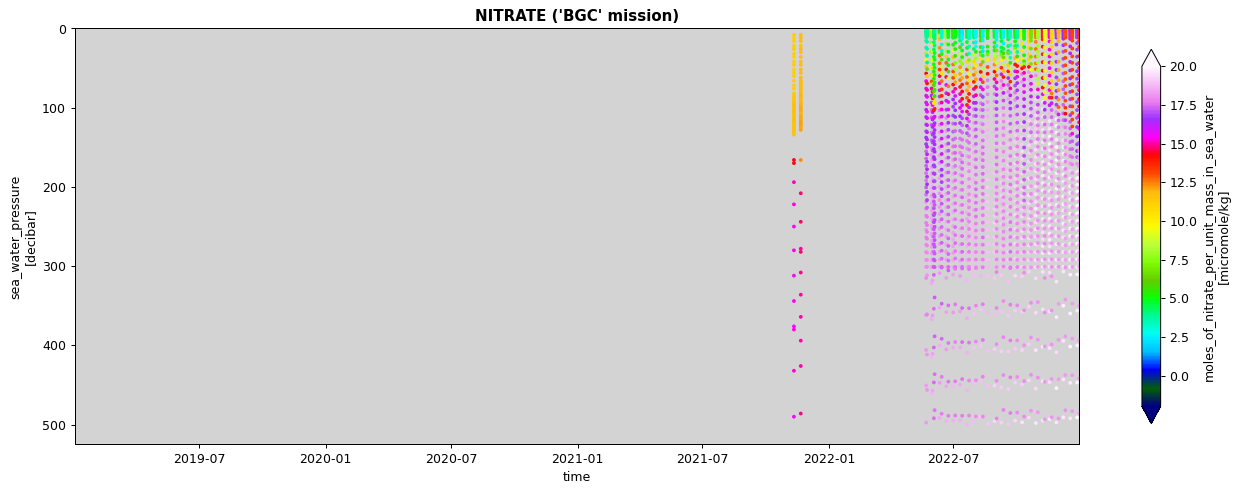

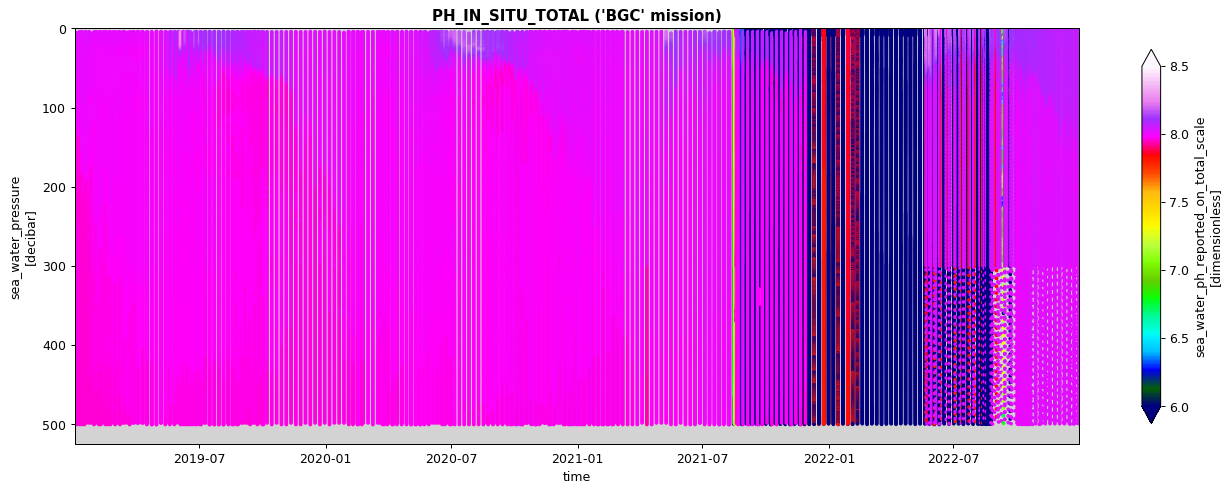

In [ ]:
# Plot all BGC params
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)    
    fig, ax = scatter_plot(ds, param, vmin=vmin, vmax=vmax)
    ax.set_title("%s ('%s' mission)" % (param, f.mission), fontdict={'weight': 'bold', 'size': 12});